# Reproduction of the rVAE_chemtransform paper 
[https://www.science.org/doi/10.1126/sciadv.abd5084]

In [1]:
from typing import Dict, Tuple, Union

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn import cluster, mixture, decomposition

import cv2

In [2]:
STEM_real = np.load('./assets/3DStack13-1-exp.npy')
decoded_imgs = np.load('./assets/3DStack13-1-dec.npy')
lattice_coord = np.load('./assets/3DStack13-1-coord.npy', allow_pickle=True)[()]

In [3]:
C_cnt = 0
for i in lattice_coord.keys():
    coord_arr = lattice_coord[i]
    inner_cnt = len(coord_arr) - np.count_nonzero(coord_arr[:, -1])
    C_cnt += inner_cnt


print(f"There are {C_cnt} carbon atoms in all STEM frames")

There are 85033 carbon atoms in all STEM frames


Text(0.5, 1.0, 'Atomic coordinates')

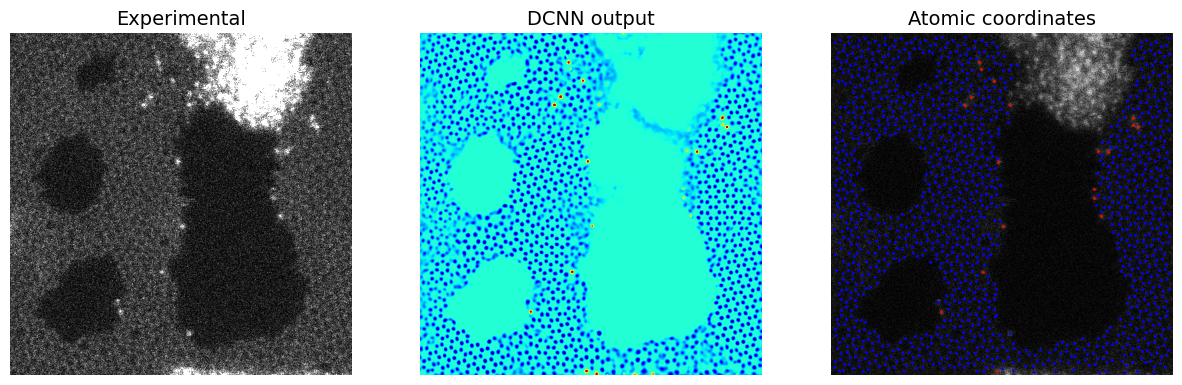

In [4]:
i = 49  # Choose movie frame

# Squeeze the channels in the predicted image (this is optional)
d_img = np.uint8(decoded_imgs[i] * 255)
d_img = cv2.cvtColor(d_img, cv2.COLOR_BGR2GRAY)
# Get coordinates for C and Si atoms
lattice_coord_ = lattice_coord[i]
coord_Si = lattice_coord[i][np.where(lattice_coord[i][:, 2] == 1)][:, 0:2]
coord_C = lattice_coord[i][np.where(lattice_coord[i][:, 2] == 0)][:, 0:2]
# Plotting
fig = plt.figure(figsize=(15, 10), dpi=100)
ax1 = fig.add_subplot(131)
ax1.imshow(STEM_real[i, :, :, 0], vmin=0, vmax=0.3, cmap="gray")
ax1.axis("off")
ax1.set_title("Experimental", fontsize=14)
ax2 = fig.add_subplot(132)
ax2.imshow(d_img, cmap="jet", interpolation="gaussian")
ax2.axis("off")
ax2.set_title("DCNN output", fontsize=14)
ax3 = fig.add_subplot(133)
ax3.scatter(coord_Si[:, 1], coord_Si[:, 0], c="red", s=1)
ax3.scatter(coord_C[:, 1], coord_C[:, 0], c="blue", s=1)
ax3.imshow(STEM_real[i, :, :, 0], cmap="gray")
ax3.axis("off")
ax3.set_title("Atomic coordinates", fontsize=14)

Create a stack of sub-images centered on C(or Si) atoms.

In [5]:
class imlocal:
    """
    STEM image local crystallography class
    highly ported from atomai https://github.com/pycroscopy/atomai/tree/master
    """

    def __init__(
        self,
        network_output: np.ndarray,
        coord_class_dict_all: Dict[int, np.ndarray],
        window_size: int = None,
        coord_class: int = 0,
    ) -> None:
        self.network_output = network_output
        self.nb_classes = network_output.shape[-1]
        self.coord_all = coord_class_dict_all
        self.coord_class = float(coord_class)
        self.r = window_size
        (self.imgstack, self.imgstack_com, self.imgstack_frames) = (
            self.extract_subimages_()
        )
        self.d0, self.d1, self.d2, self.d3 = self.imgstack.shape

    def get_imgstack(
        self,
        imgdata: np.ndarray,
        coord: np.ndarray,
        r: int,
    ) -> Tuple[np.ndarray]:

        img_cr_all = []
        com = []
        for c in coord:
            cx = int(np.around(c[0]))
            cy = int(np.around(c[1]))
            if r % 2 != 0:
                img_cr = np.copy(
                    imgdata[
                        cx - r // 2 : cx + r // 2 + 1, cy - r // 2 : cy + r // 2 + 1
                    ]
                )
            else:
                img_cr = np.copy(
                    imgdata[cx - r // 2 : cx + r // 2, cy - r // 2 : cy + r // 2]
                )
            if img_cr.shape[0:2] == (int(r), int(r)) and not np.isnan(img_cr).any():
                img_cr_all.append(img_cr[None, ...])
                com.append(c[None, ...])
        if len(img_cr_all) == 0:
            return None, None
        img_cr_all = np.concatenate(img_cr_all, axis=0)
        com = np.concatenate(com, axis=0)
        return img_cr_all, com

    def extract_subimages(
        self,
        imgdata: np.ndarray,
        coordinates: Union[Dict[int, np.ndarray], np.ndarray],
        window_size: int,
        coord_class: int = 0,
    ) -> Tuple[np.ndarray]:

        if isinstance(coordinates, np.ndarray):
            coordinates = np.concatenate(
                (coordinates, np.zeros((coordinates.shape[0], 1))), axis=-1
            )
            coordinates = {0: coordinates}
        if np.ndim(imgdata) == 2:
            imgdata = imgdata[None, ..., None]
        subimages_all, com_all, frames_all = [], [], []
        for i, (img, coord) in enumerate(zip(imgdata, coordinates.values())):
            coord_i = coord[np.where(coord[:, 2] == coord_class)][:, :2]
            stack_i, com_i = self.get_imgstack(img, coord_i, window_size)
            if stack_i is None:
                continue
            subimages_all.append(stack_i)
            com_all.append(com_i)
            frames_all.append(np.ones(len(com_i), int) * i)
        if len(subimages_all) > 0:
            subimages_all = np.concatenate(subimages_all, axis=0)
            com_all = np.concatenate(com_all, axis=0)
            frames_all = np.concatenate(frames_all, axis=0)
        return subimages_all, com_all, frames_all

    def extract_subimages_(self) -> Tuple[np.ndarray]:

        imgstack, imgstack_com, imgstack_frames = self.extract_subimages(
            self.network_output, self.coord_all, self.r, self.coord_class
        )
        return imgstack, imgstack_com, imgstack_frames

In [6]:
## sub-image reductive analysis part
def gmm(
    imgstack: np.ndarray,
    imgstack_com: np.ndarray,
    imgstack_frm: np.ndarray,
    n_components: int,
    covariance: str = "diag",
    random_state: int = 42,
    window_size: int = 24,
    plot_results: bool = True,
):
    clf = mixture.GaussianMixture(
        n_components=n_components, covariance_type=covariance, random_state=random_state
    )

    d0, d1, d2, d3 = imgstack.shape
    X_vec = imgstack.reshape(d0, d1 * d2 * d3)
    classes = clf.fit_predict(X_vec) + 1

    cla = np.ndarray(shape=(np.amax(classes), window_size, window_size, 1))
    ## plot results
    if plot_results:
        rows = int(np.ceil(float(n_components) / 5))
        cols = int(np.ceil(float(np.amax(classes)) / rows))
        fig = plt.figure(figsize=(4 * cols, 4 * (1 + rows // 2)))
        gs = gridspec.GridSpec(rows, cols)
        print("\nGMM COMPONENTS")
    cl_all = []
    for i in range(np.amax(classes)):
        cl = imgstack[classes == i + 1]  # 4d
        cl_all.append(cl)
        cla[i] = np.mean(cl, axis=0)  # 4d list
        if plot_results:
            ax = fig.add_subplot(gs[i])
            ax.imshow(cla[i, :, :, 0], cmap="seismic", interpolation="Gaussian")
            ax.axis("off")
            ax.set_title("Class " + str(i + 1) + "\nCount: " + str(len(cl)))

    if plot_results:
        plt.subplots_adjust(hspace=0.6, wspace=0.4)
        plt.show()
    com_frames = np.concatenate(
        (imgstack_com, classes[:, None], imgstack_frm[:, None]), axis=-1
    )
    return cla, cl_all, com_frames

In [7]:
s = imlocal(np.sum(decoded_imgs[..., :-1], -1)[..., None], lattice_coord, 24, 0)

In [8]:
imgstack, imgstack_com, imgstack_frm = s.imgstack, s.imgstack_com, s.imgstack_frames

The block of code below takes a while to complete

In [9]:
# cla, cl_all, com_frames = gmm(
#     imgstack=imgstack,
#     imgstack_com=imgstack_com,
#     imgstack_frm=imgstack_frm,
#     n_components=16,
# )

In [10]:
import os
from pathlib import Path

from models.vanilla_vae import VanillaVAE
from models import fcVAE, rVAE
from experiment import VAEXperiment

import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from lightning_fabric.utilities.seed import seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

Using CUDA device.
Using CUDA device.
Using CUDA device.


In [11]:
imstack_train, imstack_test = train_test_split(
    imgstack,
    test_size=0.15,
    shuffle=True,
    random_state=42,
)
print(f"train stack shape: {imstack_train.shape},\ntest stack shape: {imstack_test.shape}")

train stack shape: (68056, 24, 24, 1),
test stack shape: (12011, 24, 24, 1)


## DeepLearning : Dataset & DataLoader

In [12]:
train_dataset, val_dataset = TensorDataset(
    torch.from_numpy(
        imstack_train.transpose(0, 3, 1, 2).reshape(len(imstack_train), -1)
    )
), TensorDataset(
    torch.from_numpy(imstack_test.transpose(0, 3, 1, 2).reshape(len(imstack_test), -1)),
)  

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=100,
    shuffle=True,
    num_workers=4,
    persistent_workers=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=100,
    shuffle=False,
    num_workers=4,
    persistent_workers=True,
)

## VAE Analysis

In [13]:
RESULT_DIR = r"./"
tb_logger = TensorBoardLogger(
    save_dir=os.path.join(RESULT_DIR, "tb_logs"), name="fcVAE"
)

seed_everything(1265, True)

# model = VanillaVAE(in_channels=1, latent_dim=200, hidden_dims=[16, 32, 64], img_size = 24)
model = fcVAE(in_dim=576)

exp_params = {
    "LR": 0.005,
    "weight_decay": 0.0,
    "scheduler_gamma": 0.95,
    "kld_weight": 0.00025,
}

experiment = VAEXperiment(model, exp_params)

runner = Trainer(
    logger=tb_logger,
    callbacks=[
        LearningRateMonitor(),
        ModelCheckpoint(
            save_top_k=2,
            dirpath=os.path.join(tb_logger.log_dir, "checkpoints"),
            monitor="val_loss",
            save_last=True,
        ),
    ],
    # strategy=DDPStrategy(accelerator="cpu"),
    max_epochs=200,
)

Path(f"{tb_logger.log_dir}/Samples").mkdir(exist_ok=True, parents=True)
Path(f"{tb_logger.log_dir}/Reconstructions").mkdir(exist_ok=True, parents=True)

Seed set to 1265
Missing logger folder: ./tb_logs/fcVAE
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:
runner.fit(experiment, train_dataloaders=train_loader, val_dataloaders=val_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type  | Params
--------------------------------
0 | model | fcVAE | 378 K 
--------------------------------
378 K     Trainable params
0         Non-trainable params
378 K     Total params
1.515     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


## rVAE analysis

In [15]:
train_dataset, val_dataset = TensorDataset(
    torch.from_numpy(imstack_train.transpose(0, 3, 1, 2))
), TensorDataset(
    torch.from_numpy(imstack_test.transpose(0, 3, 1, 2)),
)  ## both are [24 24 1]

# train_dataset, val_dataset = TensorDataset(
#     torch.from_numpy(
#         imstack_train.transpose(0, 3, 1, 2).reshape(len(imstack_train), -1)
#     )
# ), TensorDataset(
#     torch.from_numpy(imstack_test.transpose(0, 3, 1, 2).reshape(len(imstack_test), -1)),
# )  

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=100,
    shuffle=True,
    num_workers=4,
    persistent_workers=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=100,
    shuffle=False,
    num_workers=4,
    persistent_workers=True,
)

In [16]:
RESULT_DIR = r"./"
tb_logger = TensorBoardLogger(save_dir=os.path.join(RESULT_DIR, "tb_logs"), name="rVAE")

seed_everything(1265, True)

# model = VanillaVAE(in_channels=1, latent_dim=200, hidden_dims=[16, 32, 64], img_size = 24)
model = rVAE(
    in_dim=(24, 24),
    latent_dim=2,
    hidden_dims=[512, 512],
    # softplus_out=1,
)

exp_params = {
    "LR": 0.0005,
    "weight_decay": 0.0,
    "scheduler_gamma": 0.95,
    "kld_weight": 0.00025,
}

experiment = VAEXperiment(model, exp_params)

runner = Trainer(
    logger=tb_logger,
    callbacks=[
        LearningRateMonitor(),
        ModelCheckpoint(
            save_top_k=2,
            dirpath=os.path.join(tb_logger.log_dir, "checkpoints"),
            monitor="val_loss",
            save_last=True,
        ),
    ],
    # strategy=DDPStrategy(accelerator="cpu"),
    max_epochs=200,
)

Path(f"{tb_logger.log_dir}/Samples").mkdir(exist_ok=True, parents=True)
Path(f"{tb_logger.log_dir}/Reconstructions").mkdir(exist_ok=True, parents=True)

Seed set to 1265
Missing logger folder: ./tb_logs/rVAE
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [17]:
runner.fit(experiment, train_dataloaders=train_loader, val_dataloaders=val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | rVAE | 1.1 M 
-------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.366     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
